# Import

In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import seaborn as sns


# Recupération des données

In [95]:
df = pd.read_csv("data/train.csv", sep=',')

In [96]:
df.columns[159]

'PSASUGST'

In [97]:

A_garder = ['CRVCLHPV', 'HADHYST2', 'COLNSIGM', "COLNCNCR", 'VIRCOLO1', "SMALSTOL", 'STOOLDN2', 'SMOKE100', 'SMOKDAY2',
            'USENOW3', 'ECIGNOW2', 'LCSFIRST', 'LCSLAST', 'LCSNUMCG', 'LCSCTSC1', 'LCSSCNCR', 'ALCDAY4', 'AVEDRNK3',
            'DRNK3GE5', "MAXDRNKS", 'HIVRISK5', 'COVIDPOS', 'COVIDSMP', 'COVIDPRM', 'PDIABTS1', 'PREDIAB2', 'DIABTYPE',
            'FEETSORE', 'TOLDCFS', 'HAVECFS', 'COPDCOGH', 'COPDFLEM', 'COPDBRTH', 'COPDBTST', 'COPDSMOK', 'CNCRDIFF', 
            'CSRVDOC1', 'CSRVDEIN', 'CSRVPAIN', 'CSRVCTL2', 'PSATEST1', 'PCPSARS2']

# BLDSTFIT = blood test en fonction d'avant un autre test
# 'COLNTES1', 'HADSIGM4', "SIGMTES1", 'LASTSIG4', 'VCLNTES2', 'STOLTEST', 'SDNATES1', 'LCSCTWHN', 'HIVTSTD3, COVIDFS1, COVIDSE1, PSATIME1 : date des teste
# 'FLUSHOT7', 'FLSHTMY3', 'PNEUVAC4', 'HIVTST7, 'IMFVPLA3, HPVADVC4, HPVADSHT, COVIDVA1  : vaccins
peut_etre = ['COLNTES1', 'HADSIGM4', "SIGMTES1", 'LASTSIG4', 'VCLNTES2', 'STOLTEST', 'SDNATES1', 'LCSCTWHN', 'BLDSTFIT', 
             'FLUSHOT7', 'FLSHTMY3', 'PNEUVAC4', 'TETANUS1', 'HIVTST7', 'HIVTSTD3', 'IMFVPLA3', 'HPVADVC4', 'HPVADSHT',
             'SHINGLE2', 'COVIDVA1', 'COVIDNU1', 'COVIDFS1', 'COVIDSE1', 'PSATIME1'] 

A_enlever = ['INSULIN1', 'CHKHEMO3', 'EYEEXAM1', 'DIABEYE1', 'DIABEDU1', 'WORKCFS', 'CSRVSUM', 'CSRVRTRN', 'CSRVINST',
             'CSRVINSR', 'CSRVCLIN', 'PSASUGST']

In [ ]:
def plot_nan_proportion(df):
    """
    Affiche la proportion de valeurs manquantes (NaN) pour chaque colonne d'un DataFrame.
    """
    nan_proportion = df.isna().sum().sort_values(ascending=False) / len(df)

    plt.figure(figsize=(12, 6))
    plt.bar(nan_proportion.index, nan_proportion.values)
    plt.xticks(rotation=90)
    plt.ylabel("Proportion de NaN")
    plt.title("Proportion de valeurs manquantes par colonne")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

    return nan_proportion

In [114]:
import yaml

with open('features.yaml', "r", encoding="utf-8") as yaml_file:
    yaml_content = yaml.load(yaml_file, Loader=yaml.SafeLoader)   

features = yaml_content['features']

In [117]:
df_clean = df[features]

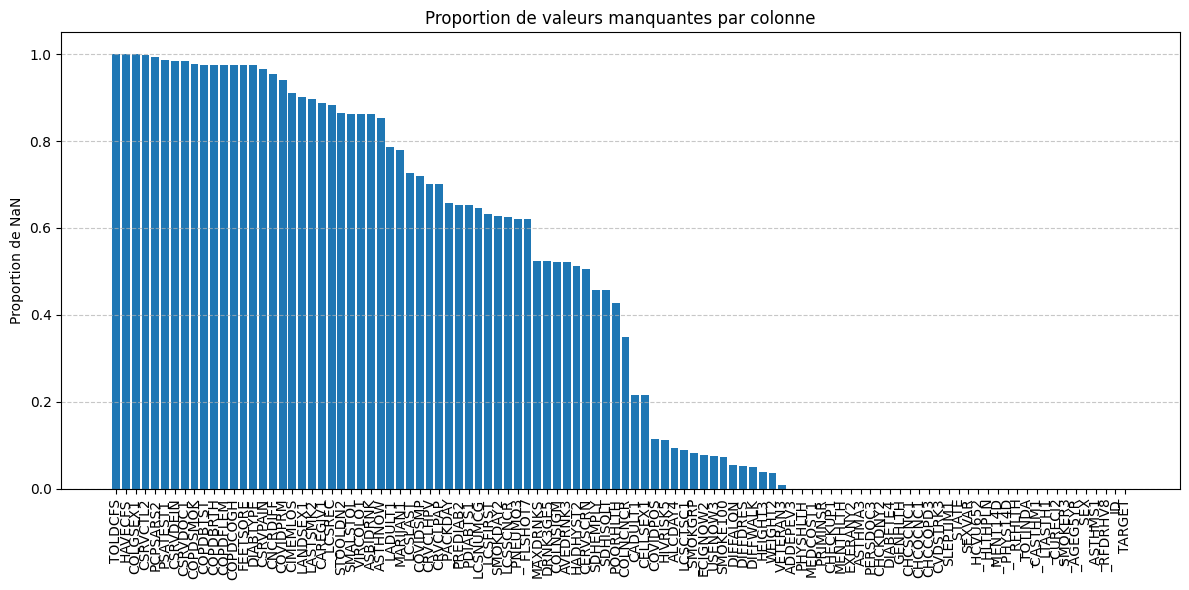

In [118]:
nan_proportion = plot_nan_proportion(df_clean)

In [135]:
def clean_data(df, suppr):

    for col in df.columns:
        if col in suppr:
            df = df.drop(col, axis = 1)
            
    nan_proportion = df.isna().sum().sort_values(ascending=False) / len(df)
    
    for i, prop in enumerate(nan_proportion.values):
        if prop > 0.90:
            print(nan_proportion.index[i])

    return df



In [133]:
A_supprimer = ["TOLDCFS", 'HAVECFS', 'COLGSEX1', 'CSRVCTL2', 'PCPSARS2', 'CSRVDEIN', 'CSRVDOC1', 'COPDFLEM', 'COPDCOGH',
               'FEETSORE', 'COVIDPRM', 'LANDSEX1']

A_clean = ["CSRVPAIN", 'PSATEST1', 'COPDSMOK', 'COPDBTST', 'COPDBRTH', 'DIABTYPE', 'CNCRDIFF', 'CIMEMLOS']

In [161]:
df_clean = clean_data(df_clean, A_supprimer)

X = df_clean.drop('TARGET', axis=1)
y = df_clean['TARGET']

PSATEST1
COPDSMOK
COPDBTST
COPDBRTH
DIABTYPE
CSRVPAIN
CNCRDIFF
CIMEMLOS


In [ ]:
xgb =  XGBClassifier(n_estimators=51)

xgb.fit(X, y)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


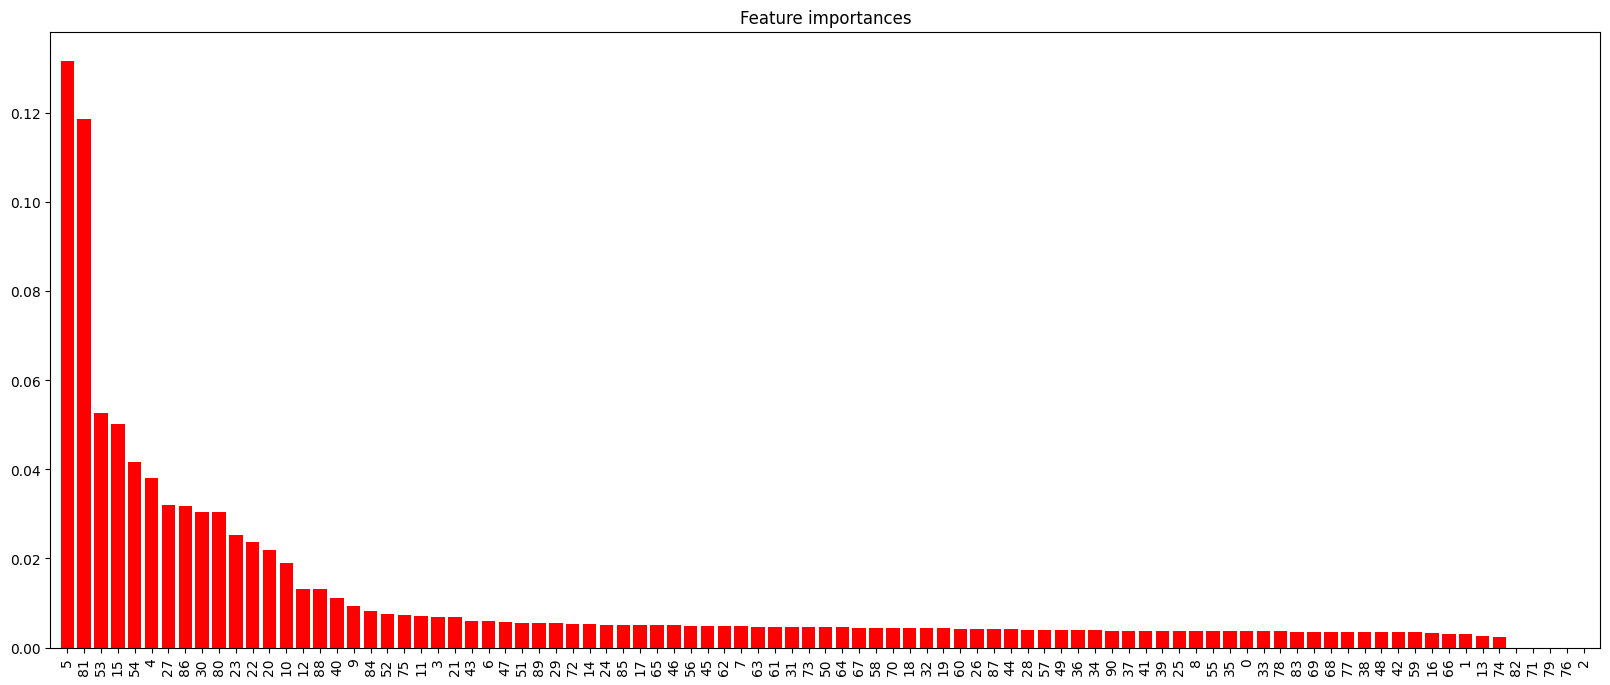

In [162]:
importances = xgb.feature_importances_
indices = np.argsort(importances)[::-1]


plt.figure(figsize=(20,8))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X.shape[1]), indices, rotation = 90)
plt.xlim([-1, X.shape[1]])
plt.show()

In [159]:
mi_cumsum = importances[indices].cumsum()
mi_total = importances[indices].sum()

threshold = 0.95 * mi_total
features_99 = mi_cumsum[mi_cumsum <= threshold]
indice = indices[mi_cumsum <= threshold]
print("Nombre de features conservées :", len(features_99))
print("Features conservées :", indice)

Nombre de features conservées : 70
Features conservées : [ 5 81 53 15 54  4 27 86 30 80 23 22 20 10 12 88 40  9 84 52 75 11  3 21
 43  6 47 51 89 29 72 14 24 85 17 65 46 56 45 62  7 63 61 31 73 50 64 67
 58 70 18 32 19 60 26 87 44 28 57 49 36 34 90 37 41 39 25  8 55 35]


array([nan,  1.])

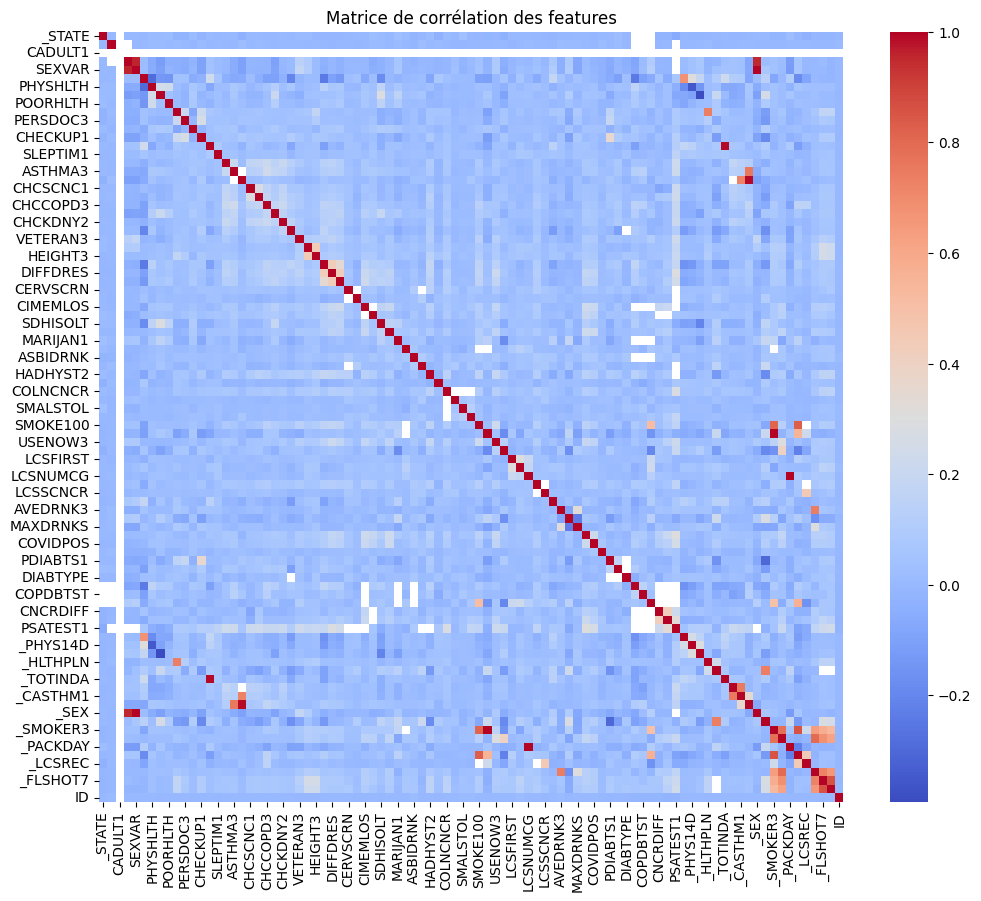

In [178]:
corr = X.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title("Matrice de corrélation des features")
plt.show()

In [176]:
for i in range(len(corr.values)):
    for j in range(i, len(corr.values[0])):
        if corr.values[i,j] > 0.9 and corr.values[i,j] != 1.0:
            print(f"forte corrélation entre {X.columns[i]} et {X.columns[j]}")

forte corrélation entre CELLSEX1 et SEXVAR
forte corrélation entre CELLSEX1 et _SEX
forte corrélation entre SEXVAR et _SEX
forte corrélation entre EXERANY2 et _TOTINDA
forte corrélation entre ASTHNOW et _ASTHMS1
forte corrélation entre SMOKDAY2 et _SMOKER3
forte corrélation entre LCSNUMCG et _PACKDAY
